In [1]:
import cv as cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import nibabel as nib

base_path = "c:/Users/bsterling/Desktop/3DBioImaging/Zebrafish/"
os.getcwd()

'C:\\Users\\bsterling\\Desktop\\3DBioImaging\\Zebrafish'

In [2]:
img_array = np.load('abs_mask.npy')

In [3]:
a = nib.load(base_path + "output.nii.gz")
img_array = np.array(a.dataobj)

In [4]:
pc = []
scale = 2
for n in range(np.shape(img_array)[2]):
    tmp = np.where(img_array[:,:,n] > 0)
    for i in range(len(tmp[0])):
        pc.append([tmp[0][i],tmp[1][i], n/scale])
pc = np.array(pc)

In [5]:
np.shape(img_array)

(512, 512, 40)

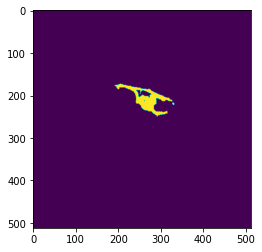

In [6]:
plt.imshow(img_array[:,:,0])

In [7]:
import pyvista as pv
import pyvistaqt as pvqt

In [8]:
# Note: ipyvtklink is needed (can be installed normally with pip)
cloud = pv.PolyData(pc)
cloud.plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [9]:
volume = cloud.delaunay_3d(alpha=10.)

In [10]:
shell = volume.extract_geometry()

In [11]:
shell.plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [12]:
p = pvqt.BackgroundPlotter()
p.set_background('white')
# p.show_bounds(grid='front', location='outer', all_edges=True)
p.add_bounding_box(line_width=2, color= 'black')
p.add_mesh(shell,opacity=0.7, smooth_shading=True,
                 silhouette=dict(line_width=1, color='grey'))
p.show()

In [13]:
volume = shell.volume
volume

18519.03881407906

In [14]:
bodies = shell.split_bodies()
# Now remove all bodies with a small volume
for key in bodies.keys():
    b = bodies[key]
    vol = b.volume
    if vol < 1000.0:
        del bodies[key]
        continue
    # Now lets add a volume array to all blocks
    b.cell_arrays["TOTAL VOLUME"] = np.full(b.n_cells, vol)

In [15]:
for i, body in enumerate(bodies):
    print(f"Body {i:02d} volume: {body.volume:.3f}")

Body 00 volume: 18519.039


In [16]:
for i, body in enumerate(bodies):
    surf = body.extract_surface()
    print(f"Body {i:02d} volume: {surf.area:.3f}")

Body 00 volume: 136679.104


In [17]:
bodies.plot(scalars="TOTAL VOLUME", cmap="jet", show_grid=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [18]:
surf = shell.extract_surface()
surf.plot(show_scalar_bar=True)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [19]:
p = pvqt.BackgroundPlotter()
p.add_mesh(surf)
p.show()

In [20]:
surf.area

136679.10432643088

In [21]:
smooth = surf.smooth(n_iter=1000)
smooth.plot()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [22]:
p = pvqt.BackgroundPlotter()
p.add_mesh(smooth)
p.show()

In [23]:
qual = shell.compute_cell_quality(quality_measure='scaled_jacobian')
qual

PolyData (0x1b8ac647be0)
  N Cells:	37369
  N Points:	181684
  X Bounds:	1.710e+02, 2.800e+02
  Y Bounds:	1.590e+02, 3.890e+02
  Z Bounds:	0.000e+00, 1.950e+01
  N Arrays:	2

In [24]:
qual.plot(scalars='CellQuality')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [25]:
p = pvqt.BackgroundPlotter()
p.add_mesh(qual)
p.show()

In [26]:
import open3d as o3d

In [27]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc)
pcd.estimate_normals()

In [28]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 1.5 * avg_dist

In [29]:
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))

In [30]:
dec_mesh = bpa_mesh.simplify_quadric_decimation(50)

In [31]:
dec_mesh.remove_degenerate_triangles()
dec_mesh.remove_duplicated_triangles()
dec_mesh.remove_duplicated_vertices()
dec_mesh.remove_non_manifold_edges()

TriangleMesh with 163359 points and 50 triangles.

In [32]:
o3d.visualization.draw_geometries([bpa_mesh])

Finished exporting dataset to:  C:\Users\bsterling\Desktop\3DBioImaging\Zebrafish\1.vtkjs


In [33]:
poisson_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=10, width=0, scale=1.1, linear_fit=True)[0]

In [34]:
o3d.visualization.draw_geometries([pcd])

In [35]:
bbox = pcd.get_axis_aligned_bounding_box()
p_mesh_crop = poisson_mesh.crop(bbox)

In [36]:
o3d.visualization.draw_geometries([p_mesh_crop])